# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: CodeChallenge: Weight variance inits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

# # normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# import dataset from torchvision
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()

print(dataNorm.shape)
print(labels.shape)

torch.Size([70000, 784])
torch.Size([70000])


In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_2281715/1479885578.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( dataNorm ).float()
/tmp/ipykernel_2281715/1479885578.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).long()


# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [5]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.1205, -0.0816,  0.0049,  ..., -0.0762,  0.1044,  0.0777],
        [ 0.0954,  0.0672,  0.0791,  ...,  0.0963,  0.1017, -0.0678],
        [ 0.0437,  0.0256, -0.0281,  ...,  0.0883, -0.1195, -0.0972],
        ...,
        [ 0.0425,  0.0267, -0.0696,  ...,  0.1076,  0.0664, -0.0215],
        [-0.0418,  0.1169, -0.0195,  ..., -0.0257,  0.0919, -0.1177],
        [-0.0697, -0.1218, -0.0871,  ...,  0.0160, -0.0675,  0.0472]])


# Create a function that trains the model

In [11]:
def function2trainTheModel(net,lossfun,optimizer, numepochs=10):
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Test the model to see that works

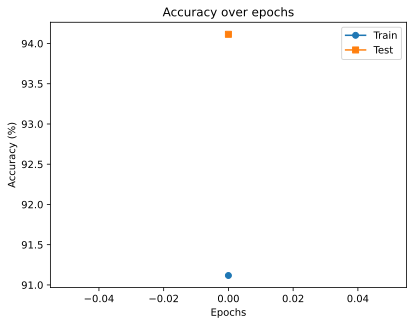

In [12]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer,numepochs=3)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Create the random weights and train the model

In [19]:
testAcc = []
trainAcc = []
weights = {}


# Generate 25 logarithmically spaced values between 0.0001 and 10
std_devs = np.logspace(np.log10(0.0001), np.log10(10), 25)

for std in std_devs:
    net,lossfun,optimizer = createTheMNISTNet()

    # Set the standard deviation of the weights
    # net.fc1.weight.data = torch.randn(64, 784) * std # this is not very elegant
    with torch.no_grad():
        for param in net.parameters():
            if len(param.shape) > 1:  # Only apply to weights, not biases
                param.normal_(0, std)
    
    trainAcc_batch,testAcc_batch,losses,net = function2trainTheModel(net,lossfun,optimizer,numepochs=10)

    testAcc.append(np.mean(testAcc_batch[-3:]))
    trainAcc.append(np.mean(trainAcc_batch[-3:]))
    weights[std] = net.fc1.weight.data

# Plot the results

(-1.0, 1.0)

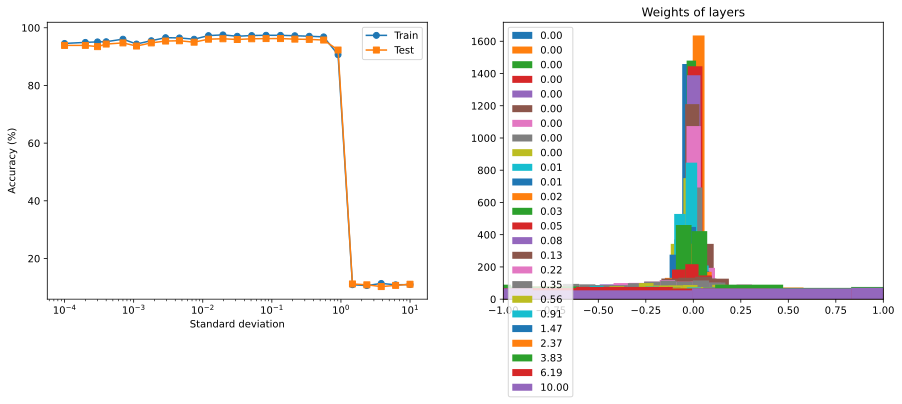

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(std_devs, trainAcc, 'o-', label='Train')
ax[0].plot(std_devs, testAcc, 's-', label='Test')
ax[0].set_xscale('log')
ax[0].set_xlabel('Standard deviation')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

# Plot the weights
for key in weights.keys():
    ax[1].hist(weights[key].numpy().flatten(), bins=80, label=f'{key:.2f}')
ax[1].set_title('Weights of layers')
ax[1].legend(loc='upper left')
ax[1].set_xlim(-1, 1)



